**To Do**
<font color="red"><ul>
    <li>let bulk of feature selection exploration happen in EDA notebook</li>
    <li>here, do final feature selection, then train/test split, then scaling</li>
    <li>keep full features for a comparison model</li>
    <li>basic hyperparameter tuning here, more extensive in next notebook</li>
</ul></font>

**New To Do**
<font color="red"><ul>
    <li>need to create dummy variable, could use 0,1 playoff/allstar games then remove</li>
    <li>model selection goes in next notebook, just do feature limitation with regression models here</li>
    <li></li>
</ul></font>

In [41]:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression,  mutual_info_regression# other ways to automatically feature select?
from sklearn.linear_model import LinearRegression, Ridge,  Lasso, SGDRegressor # Logistic Regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb

from sklearn.pipeline import make_pipeline

In [42]:
# read dataset prepared for models
# note that index has not been modified, 
# and can be used to add descriptive information 
# removed from previous cleaning steps
data = pd.read_parquet('data/game_stats_0.parquet', engine='pyarrow')

In [43]:
data.shape

(1428, 45)

In [3]:
# let y be "home_win" for classification problems
X = data.drop(
        columns = ['game','date','week','home','away','home_score','away_score', 'home_margin','home_win']
)
y = data['home_margin']


In [4]:
# train/test split, 
# test_size=0.2/0.3, default is 0.25. will ultimately determine ideal folds for cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
features = X_train.columns
print(X_train.shape)
print(X_test.shape)

(999, 36)
(429, 36)


In [8]:
X_train.sample(3)

,away_completions,away_throws,away_blocks,away_turnovers,away_o_scores,away_o_points,away_o_possessions,away_d_scores,away_d_points,away_d_possessions,...,home_hold_rate,away_hold_rate,home_o_poss_per_hold,away_o_poss_per_hold,home_break_rate,away_break_rate,home_d_poss_per_pt,away_d_poss_per_pt,home_break_per_poss,away_break_per_poss
1413,21,44,6,23,17,34,40,3,22,6,...,0.863636,0.500000,1.368421,2.352941,0.382353,0.136364,0.676471,0.272727,0.565217,0.500000
2847,259,278,9,19,16,26,29,5,23,12,...,0.739130,0.615385,1.705882,1.812500,0.269231,0.217391,0.423077,0.521739,0.636364,0.416667
1580,240,252,6,12,21,26,33,13,36,16,...,0.611111,0.807692,1.863636,1.571429,0.076923,0.361111,0.346154,0.444444,0.222222,0.812500


In [5]:
# scale data, fit to training, transform training+testing sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [128]:
pd.DataFrame(X_train, columns=features).sample(3)

,away_completions,away_throws,away_blocks,away_turnovers,away_o_scores,away_o_points,away_o_possessions,away_d_scores,away_d_points,away_d_possessions,...,home_hold_rate,away_hold_rate,home_o_poss_per_hold,away_o_poss_per_hold,home_break_rate,away_break_rate,home_d_poss_per_pt,away_d_poss_per_pt,home_break_per_poss,away_break_per_poss
138,-0.240108,-0.282342,-0.500478,-0.218161,-0.003705,0.470537,-0.093032,-0.274296,-0.393567,-0.463544,...,0.341816,-0.524578,-0.327879,-0.194758,0.639870,-0.092488,-0.299287,-0.330070,1.066029,0.163069
586,-0.337032,-0.282342,-0.940406,0.395417,1.135016,1.032369,0.964596,-0.839288,0.216319,-0.624503,...,0.535570,0.053029,-0.581903,-0.230053,0.519526,-1.037153,-0.095727,-0.764141,0.620875,-0.736217
861,-0.337032,-0.461744,1.699159,-0.709023,-1.427105,-2.338624,-1.943882,5.093131,2.655863,3.560443,...,-3.278972,1.538305,4.798034,-0.613886,-1.584184,3.487296,-0.012452,1.599134,-1.901665,1.397384


### Preprocessing, Initial Modeling
 - Split into Train / Test sets for data
 - evaluate models and data processing via pipeline, basic metrics
 - Scaling data should be beneficial
 - Feature Selection / Dimension Reduction
   - PCA, SelectKBest, manual selection? other?
 - Initial Models (chose some and tune in next notebook)
   - Linear Regression, Ridge, SGD
   - RandomForest, GradientBoosting, XGBoost

**Key Questions**
 - What treatment / transformation / decomposition of training features works best for model performance?
   - consider with simple LinearRegression model
     - can let all data through with `k='all'` for other models, test in param tuning
   - scaled vs SelectKBest vs PCA
     - how many features to use for KBest/PCA?
   - **Current Decision** --> SelectKBest (6) with scoring_function = `mutual_info_regression`
 - How should models be evaluated?
   - scoring metrics
     - MSE, RMSE, R2?
   - plot predicted vs actual
     - can illustrate with a set of games: season,team
 - Which models show best performance? Does this make sense with source data?
 - Do models show performance gain with hyperparameter tuning?
   - grid search vs random search CV
   - consider search + training time
 - Which few models to nominate for further tuning?

#### Optimize Data Treatment with Simple Models
 - Linear Regression vs Random Forest vs ?
 - scaled vs PCA decomp vs KBest

##### Part 1: scaled data vs PCA decomp vs selection via KBest
**Conclusions**
 - using entire dataset (**scaled data**) shows very good performance
   - *good baseline to consider*, for ex: what value is there to predict margin with limited data? is accuracy reduction ok given easy data input?
 - **PCA(10)** reduces performance
   - still worthwhile in evaluating feature performance
 - **SelectKBest(10)** mostly maintains perforamnce
   - *worth doing a gridsearch with various k values and scoring functions*

In [129]:
y_pred = {}
base_pipe = make_pipeline(LinearRegression())
pca_pipe = make_pipeline(PCA(n_components=10), LinearRegression())
kb_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=10), LinearRegression())

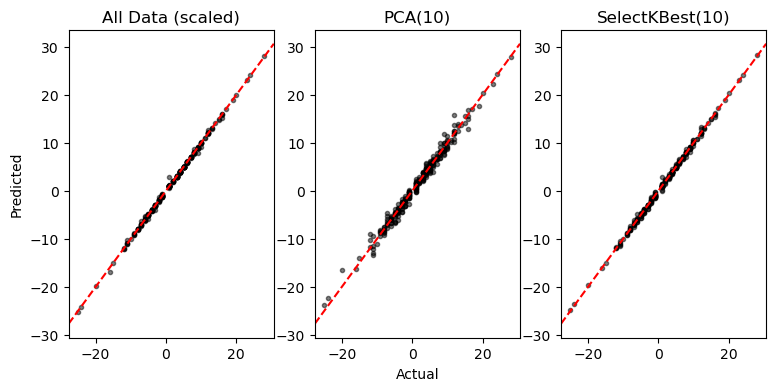

In [146]:
fig, axs = plt.subplots(1,3, figsize=(9,4))

axs[0].plot(y_test, y_pred['base'], 'k.', alpha=0.5)
xlim = axs[0].get_xlim()
axs[0].plot(xlim,xlim, 'r--')
axs[0].set_xlim(xlim)
axs[0].set_title('All Data (scaled)')
axs[0].set_xlabel('')
axs[0].set_ylabel('Predicted')

axs[1].plot(y_test, y_pred['pca'], 'k.', alpha=0.5)
xlim = axs[1].get_xlim()
axs[1].plot(xlim,xlim, 'r--')
axs[1].set_xlim(xlim)
axs[1].set_title('PCA(10)')
axs[1].set_xlabel('Actual')
axs[1].set_ylabel('')

axs[2].plot(y_test, y_pred['kb'], 'k.', alpha=0.5)
xlim = axs[2].get_xlim()
axs[2].plot(xlim,xlim, 'r--')
axs[2].set_xlim(xlim)
axs[2].set_title('SelectKBest(10)')
axs[2].set_xlabel('')
axs[2].set_ylabel('')

plt.show()

**PCA Pipeline**

In [136]:
pca_pipe.fit(X_train,y_train)
print(pca_pipe.score(X_test,y_test))
y_pred['pca'] = pca_pipe.predict(X_test)

0.9811780606485924


In [137]:
pd.DataFrame(np.abs(pca_pipe[0].components_), columns=X.columns).sum().sort_values(ascending=False).head(8)

away_blocks             2.010821
home_block_rate         1.963358
away_block_rate         1.911272
home_blocks             1.859771
away_completion_rate    1.772008
home_completion_rate    1.586438
away_completions        1.553468
away_throws             1.536061
dtype: float64

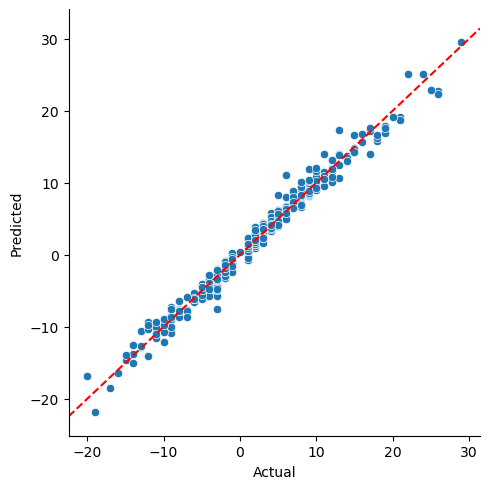

In [138]:
sns.relplot(x=y_test, y=y_pred['pca'])
xlim = plt.xlim()
plt.plot(xlim,xlim, 'r--')
plt.xlim(xlim)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

**Select K Best pipeline**

In [15]:
kb_pipe.fit(pd.DataFrame(X_train, columns=X.columns),y_train)
print(kb_pipe.score(pd.DataFrame(X_test, columns=X.columns),y_test))
y_pred['kb'] = kb_pipe.predict(pd.DataFrame(X_test, columns=X.columns))

0.9983694455177913


In [16]:
pd.DataFrame(np.abs(kb_pipe[-1].coef_), index = kb_pipe[0].get_feature_names_out()).sort_values(0,ascending=False).head()

,0
home_d_scores,4.340393
away_d_scores,3.397611
away_hold_rate,1.672203
home_hold_rate,1.398470
home_break_rate,1.298332


In [17]:
pd.DataFrame(kb_pipe[0].scores_[:10], index = kb_pipe[0].get_feature_names_out()).sort_values(0,ascending=False).head(7)

,0
away_hold_rate,2032.383638
home_d_possessions,971.875785
away_break_rate,942.581242
home_hold_rate,930.199798
home_break_rate,806.507376
home_d_scores,405.816090
away_d_possessions,230.253962


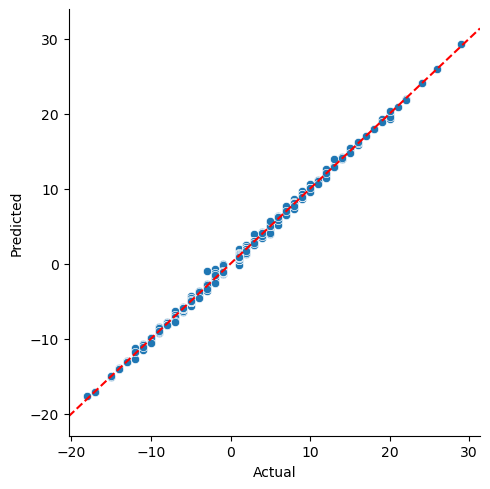

In [18]:
sns.relplot(x=y_test, y=y_pred['kb'])
xlim = plt.xlim()
plt.plot(xlim,xlim, 'r--')
plt.xlim(xlim)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

**Base Pipeline - all data**

In [144]:
base_pipe.fit(X_train,y_train)
print(base_pipe.score(X_test,y_test))
y_pred['base'] = base_pipe.predict(X_test)

0.9989398208700998


In [147]:
pd.DataFrame(np.abs(base_pipe[-1].coef_), index = X.columns).sort_values(0,ascending=False).head()

,0
away_completions,4.543254e+12
away_throws,4.418184e+12
away_turnovers,7.176773e+11
home_completions,9.218818e+10
home_throws,9.184545e+10


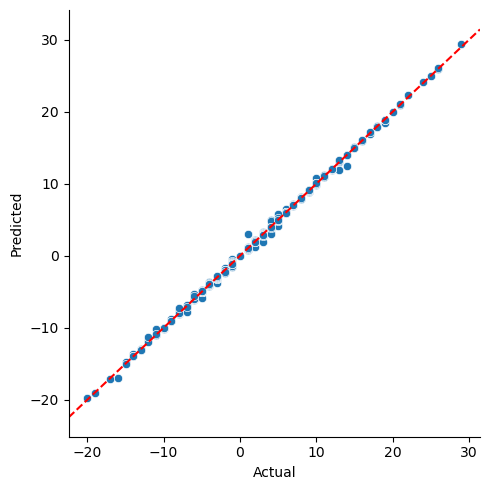

In [146]:
sns.relplot(x=y_test, y=y_pred['base'])
xlim = plt.xlim()
plt.plot(xlim,xlim, 'r--')
plt.xlim(xlim)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

##### Part 2: KBest GridSearchCV
- k [1,10]
- scoring_func = f_regression, mutual_info_regression

**Conclusions**
 - k 7-10 peak performance, both score functions
 - mutual information better than f_regression for some k, more prominent at low k
 - `k=6, score_func=mutual_info_regression`

In [22]:
ks = [val+1 for val in range(10)]
kb_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=10), LinearRegression())
grid_params = {
    'selectkbest__k': ks,
    'selectkbest__score_func': [f_regression, mutual_info_regression]
}

In [23]:
cv = GridSearchCV(kb_pipe, param_grid=grid_params, cv=5,
                  scoring='neg_root_mean_squared_error', 
                  n_jobs=-1,)

In [24]:
%%time
cv.fit(X_train,y_train)

CPU times: total: 328 ms
Wall time: 4.98 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000018CE2D01360>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'selectkbest__score_func': [<function f_regression at 0x0000018CE2D01360>,
                                                     <function mutual_info_regression at 0x0000018CE75CF5B0>]},
             scoring='neg_root_mean_squared_error')

In [28]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selectkbest__k,param_selectkbest__score_func,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019001,0.005018,0.001801,3.994343e-04,1,<function f_regression at 0x0000018CE2D01360>,"{'selectkbest__k': 1, 'selectkbest__score_func...",-3.085352,-3.623526,-3.330173,-3.479427,-2.943924,-3.292480,0.249141,19
1,0.347796,0.018508,0.001599,4.891631e-04,1,<function mutual_info_regression at 0x0000018C...,"{'selectkbest__k': 1, 'selectkbest__score_func...",-3.085352,-3.623526,-3.330173,-3.479427,-2.943924,-3.292480,0.249141,19
2,0.009796,0.005492,0.001603,4.896754e-04,2,<function f_regression at 0x0000018CE2D01360>,"{'selectkbest__k': 2, 'selectkbest__score_func...",-1.124360,-3.631806,-3.331630,-1.074533,-1.078144,-2.048095,1.174523,18
3,0.328195,0.010084,0.001599,4.886638e-04,2,<function mutual_info_regression at 0x0000018C...,"{'selectkbest__k': 2, 'selectkbest__score_func...",-1.124360,-1.097453,-1.042697,-1.074533,-1.078144,-1.083438,0.026975,17
4,0.004400,0.000491,0.001199,4.009042e-04,3,<function f_regression at 0x0000018CE2D01360>,"{'selectkbest__k': 3, 'selectkbest__score_func...",-1.121435,-1.078426,-1.039469,-1.071359,-1.074366,-1.077011,0.026168,16
5,0.334600,0.014430,0.001601,4.911482e-04,3,<function mutual_info_regression at 0x0000018C...,"{'selectkbest__k': 3, 'selectkbest__score_func...",-1.121435,-1.078426,-1.039469,-0.902718,-0.926761,-1.013762,0.085248,15
6,0.004799,0.000749,0.001201,4.004762e-04,4,<function f_regression at 0x0000018CE2D01360>,"{'selectkbest__k': 4, 'selectkbest__score_func...",-0.552931,-0.513276,-0.522180,-0.562066,-0.492656,-0.528622,0.025612,13
7,0.334998,0.008486,0.001400,4.904672e-04,4,<function mutual_info_regression at 0x0000018C...,"{'selectkbest__k': 4, 'selectkbest__score_func...",-0.552931,-0.513276,-0.522180,-0.562066,-0.492656,-0.528622,0.025612,13
8,0.003801,0.000399,0.001201,4.000206e-04,5,<function f_regression at 0x0000018CE2D01360>,"{'selectkbest__k': 5, 'selectkbest__score_func...",-0.550698,-0.509849,-0.519118,-0.556645,-0.489953,-0.525253,0.025115,12
9,0.333706,0.009571,0.001400,4.894540e-04,5,<function mutual_info_regression at 0x0000018C...,"{'selectkbest__k': 5, 'selectkbest__score_func...",-0.547246,-0.509849,-0.509177,-0.548822,-0.489953,-0.521010,0.023199,11


In [26]:
results = pd.DataFrame(cv.cv_results_)  
results[['param_selectkbest__k','param_selectkbest__score_func','mean_test_score','std_test_score']]\
    .sort_values('mean_test_score',ascending=False)

,param_selectkbest__k,param_selectkbest__score_func,mean_test_score,std_test_score
18,10,<function f_regression at 0x0000018CE2D01360>,-0.376680,0.022187
16,9,<function f_regression at 0x0000018CE2D01360>,-0.377531,0.018864
17,9,<function mutual_info_regression at 0x0000018C...,-0.377723,0.019262
19,10,<function mutual_info_regression at 0x0000018C...,-0.377862,0.019386
13,7,<function mutual_info_regression at 0x0000018C...,-0.377896,0.019305
12,7,<function f_regression at 0x0000018CE2D01360>,-0.377896,0.019305
15,8,<function mutual_info_regression at 0x0000018C...,-0.378005,0.019277
14,8,<function f_regression at 0x0000018CE2D01360>,-0.378042,0.019515
11,6,<function mutual_info_regression at 0x0000018C...,-0.469922,0.072974
10,6,<function f_regression at 0x0000018CE2D01360>,-0.515359,0.023418


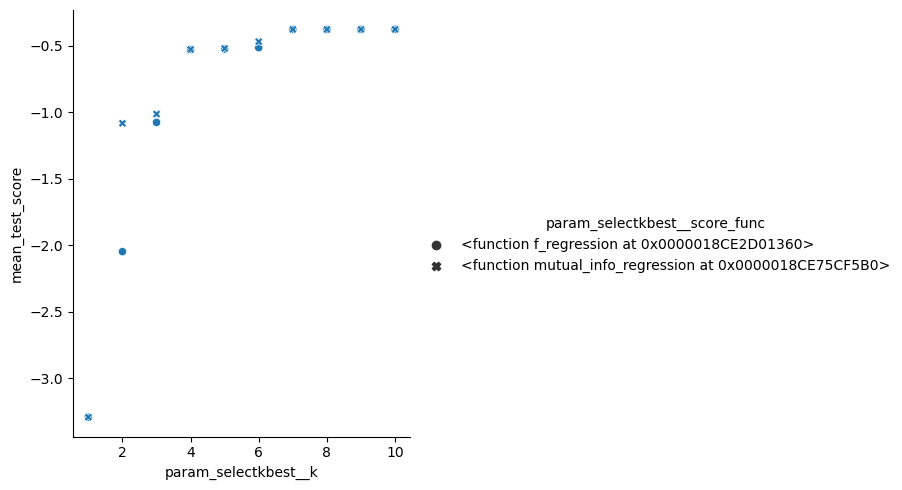

In [27]:
sns.relplot(results, x='param_selectkbest__k', y='mean_test_score', style='param_selectkbest__score_func')
plt.show()

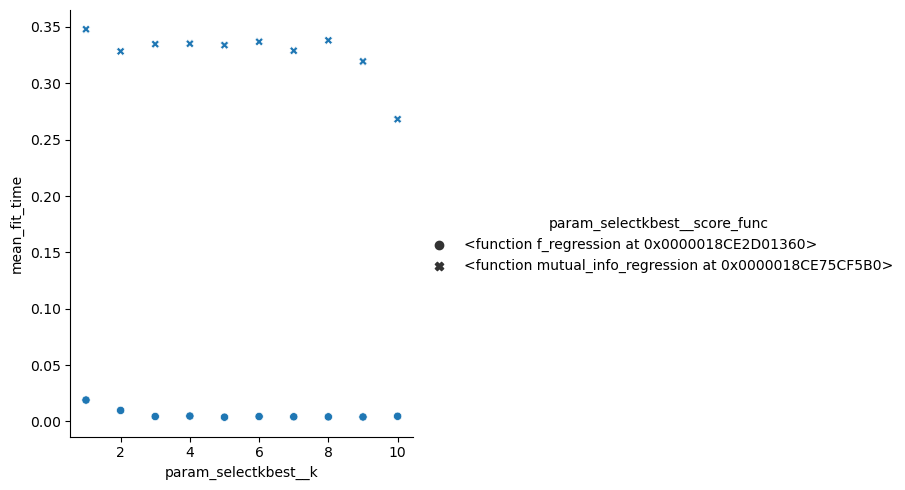

In [29]:
sns.relplot(results, x='param_selectkbest__k', y='mean_fit_time', style='param_selectkbest__score_func')
plt.show()

##### Part 3: Model Comparison
 - fit and predict using default model parameters
 - consider score, fit time
 - LinReg, Ridge, GB, XGB worth considering and tuning
   - can try full exploration of various XGB options
   - include ExtraTrees?
 - for final nomination consider stacking regressors

In [36]:
def_models = {
    'linreg': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SGD': SGDRegressor(),
    'random forest': RandomForestRegressor(),
    'et': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'xgb_linear': xgb.XGBRegressor(booster="gblinear"),
    'xgb_tree': xgb.XGBRegressor(booster="gbtree"),
}

# Ridge,  Lasso()

In [37]:
model_scores = pd.DataFrame()

In [38]:
def model_scoring(name, model):
    cv = cross_validate(model, 
                        SelectKBest(mutual_info_regression,k=6).fit_transform(X,y), 
                        #X,
                        y, 
                        cv=8, 
                        scoring='neg_root_mean_squared_error')
    model_scores.loc[name, 'score'] = round(1e3*np.mean(cv['test_score']))
    model_scores.loc[name, 'std'] = round(np.std(cv['test_score']))
    model_scores.loc[name, 'fit_time'] = round(cv['fit_time'].sum(),2)

In [39]:
%%time
for name,model in def_models.items():
    model_scoring(name,model)

CPU times: total: 26.7 s
Wall time: 15.5 s


In [40]:
model_scores.sort_values('score', ascending=False)

,score,std,fit_time
linreg,-343.0,0.0,0.01
Ridge,-441.0,0.0,0.01
et,-568.0,0.0,3.40
gradient boosting,-595.0,0.0,1.68
xgb_tree,-649.0,0.0,0.71
random forest,-692.0,0.0,6.15
SGD,-832.0,0.0,0.12
xgb_linear,-848.0,0.0,0.12
Lasso,-1100.0,0.0,0.01


In [35]:
model_scores.sort_values('score', ascending=False)

,score,std,fit_time
et,-560.0,0.0,3.39
gradient boosting,-598.0,0.0,1.66
hist,-743.0,0.0,3.69
bag,-760.0,0.0,0.64
ada,-1464.0,0.0,1.08


##### Part 4: XGBoost
 - have not used outside of tutorial thus far | [guide](https://xgboost.readthedocs.io/en/stable/tutorials/model.html)
 - [parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)
   - various `boster`'s available, default is `gbtree`
     - specific parameters when using tree booster: learning rate, max_depth, etc . . .
   - `gblinear` booster also has options

### Preliminary Tuning
*provide final model selections for next step*

  - linear regression models relatively fast, so can utilize full grid search instead of randomzied search
  - random search more appropriate for GradientBoosting, ExtraTrees which have longer fit times
  - relatively large range and few points for now, centered around default when possible
  - plot relationships and view results tables
    - cv score (X_train folded 5 times), test score (X_test)
    - best estimator predictions vs actual

##### LinReg, Ridge start

In [ ]:
ks = [val+1 for val in range(10)]
kb_pipe = make_pipeline(SelectKBest(score_func=f_regression, k=10), LinearRegression())

In [ ]:
grid_params = {
    'selectkbest__k': ks,
    'selectkbest__score_func': [f_regression, mutual_info_regression]
}

In [ ]:
cv = GridSearchCV(kb_pipe, param_grid=grid_params, cv=5,
                  scoring='neg_root_mean_squared_error', 
                  n_jobs=-1,)

In [ ]:
%%time
cv.fit(X_train,y_train)

In [ ]:
results = pd.DataFrame(cv.cv_results_)

In [ ]:
##### Part 2: KBest GridSearchCV

In [ ]:
##### Part 2: KBest GridSearchCV